#### This notebook is an analysis to identify what day is ideal to get a high number of shares

In [1]:
# imports
import pandas as pd
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from io import StringIO
import numpy as np
from scipy.stats import levene
from scipy.stats import ttest_ind

In [12]:
# Load the dataset
data = pd.read_csv('./OnlineNewsPopularity.csv', delimiter=',\s*', engine='python')

In [14]:
# Function to determine the weekday
def get_day(row):
    if row['weekday_is_monday'] == 1:
        return 'Monday'
    elif row['weekday_is_tuesday'] == 1:
        return 'Tuesday'
    elif row['weekday_is_wednesday'] == 1:
        return 'Wednesday'
    elif row['weekday_is_thursday'] == 1:
        return 'Thursday'
    elif row['weekday_is_friday'] == 1:
        return 'Friday'
    elif row['weekday_is_saturday'] == 1:
        return 'Saturday'
    else:
        return 'Sunday'


# Apply the function to each row to create the Category column
data['Day'] = data.apply(get_day, axis=1)

# Filter out rows that do not belong to any category
filtered_data = data[data['Day'] != '']

In [15]:
filtered_data['Day'].value_counts()

Wednesday    7435
Tuesday      7390
Thursday     7267
Monday       6661
Friday       5701
Sunday       2737
Saturday     2453
Name: Day, dtype: int64

<ipython-input-16-3e2061fb3b67>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Day', y='shares', data=filtered_data, showfliers=False, palette="pastel")  # Exclude outliers for clarity


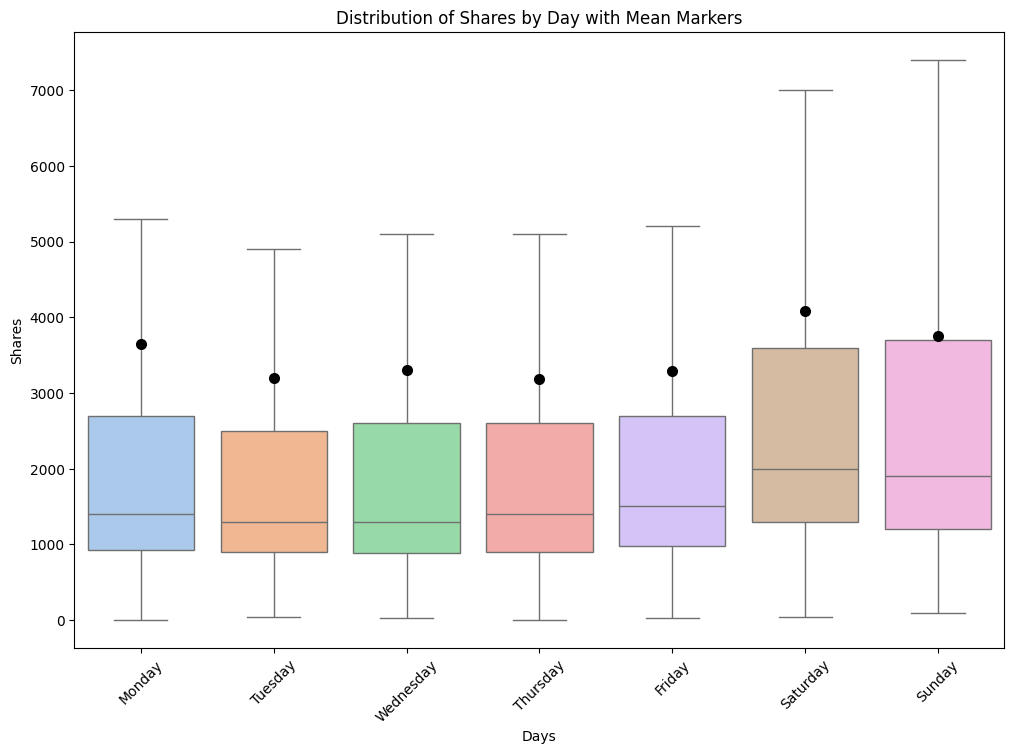

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the desired order of days
desired_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Convert the 'Day' column to categorical data type with the desired order
filtered_data['Day'] = pd.Categorical(filtered_data['Day'], categories=desired_order, ordered=True)

plt.figure(figsize=(12, 8))
sns.boxplot(x='Day', y='shares', data=filtered_data, showfliers=False, palette="pastel")  # Exclude outliers for clarity

# Calculate mean shares for each category and overlay as points to take outliers into account as well
means = filtered_data.groupby('Day')['shares'].mean().reset_index()
mean_points = sns.stripplot(x='Day', y='shares', data=means, color='black', size=8, jitter=0)  # Set jitter to 0

plt.title('Distribution of Shares by Day with Mean Markers')
plt.ylabel('Shares')
plt.xlabel('Days')
plt.xticks(rotation=45)
# plt.legend()
plt.show()


<ipython-input-17-dfe7a17f43b3>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Day', data=filtered_data, palette='pastel')


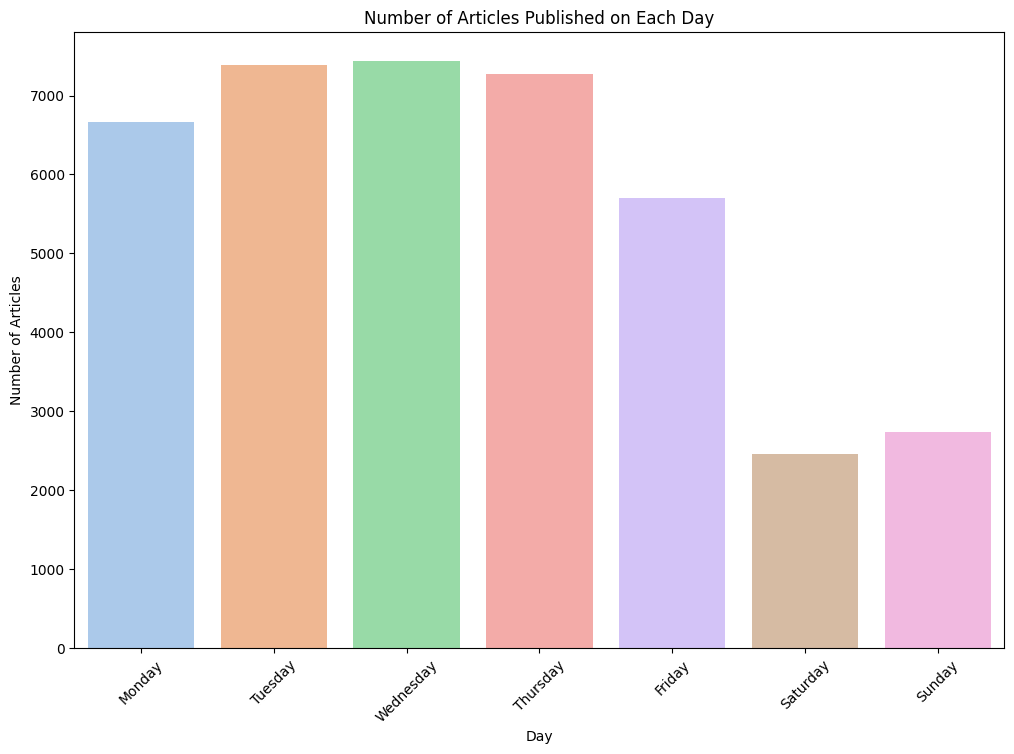

In [17]:
plt.figure(figsize=(12, 8))
sns.countplot(x='Day', data=filtered_data, palette='pastel')
plt.title('Number of Articles Published on Each Day')
plt.xlabel('Day')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.show()

In [43]:

# Extract shares for each weekday
shares_monday = filtered_data[filtered_data['Day'] == 'Monday']['shares']
shares_tuesday = filtered_data[filtered_data['Day'] == 'Tuesday']['shares']
shares_wednesday = filtered_data[filtered_data['Day'] == 'Wednesday']['shares']
shares_thursday = filtered_data[filtered_data['Day'] == 'Thursday']['shares']
shares_friday = filtered_data[filtered_data['Day'] == 'Friday']['shares']
shares_saturday = filtered_data[filtered_data['Day'] == 'Saturday']['shares']
shares_sunday = filtered_data[filtered_data['Day'] == 'Sunday']['shares']

# Perform Levene's test for equal variances
statistic, p_value_levene = stats.levene(shares_monday, shares_tuesday, shares_wednesday, shares_thursday, shares_friday, shares_saturday, shares_sunday)
print("Levene's test statistic:", statistic)
print("Levene's test p-value:", p_value_levene)

# Check the p-value
alpha = 0.05
if p_value_levene < alpha:
    print("There are significant differences in the variances across days of the week.")
else:
    print("There are no significant differences in the variances across days of the week.")


# Perform one-way ANOVA test
f_statistic, p_value = stats.f_oneway(shares_monday, shares_tuesday, shares_wednesday, shares_thursday, shares_friday, shares_saturday, shares_sunday)
print(f_statistic)
print(p_value)
# Check the p-value
alpha = 0.05
if p_value < alpha:
    print("There are significant differences in the average number of shares across days of week.")
else:
    print("There are no significant differences in the average number of shares across days of week.")


Levene's test statistic: 1.5402961006730236
Levene's test p-value: 0.16046245142057783
There are no significant differences in the variances across days of the week.
3.2705807228469483
0.0032356452506011003
There are significant differences in the average number of shares across days of week.


Before running Tukey's HSD (Honestly Significant Difference) test, you should confirm several assumptions and conditions:

Independence: Data points should be independent of each other. (Data is for different articles, so it is independent)

Normality: Data for each day is over 30, hence with CLT we can say it's normaly distributed.

Homogeneity of variances (homoscedasticity): The variances of the dependent variable should be approximately equal across groups. You can check this assumption using Levene's test or Bartlett's test.

Equal sample sizes: Tukey's HSD is robust to unequal sample sizes, but it's best to have roughly equal group sizes if possible.

Random sampling: Data should be collected through random sampling methods to ensure that the sample is representative of the population.

In [19]:
# Perform Levene's test for homogeneity of variances
statistic, p_value_levene = levene(shares_monday, shares_tuesday, shares_wednesday, shares_thursday, shares_friday, shares_saturday, shares_sunday)
print("Levene's test statistic:", statistic)
print("p-value for Levene's test:", p_value_levene)

alpha = 0.05
if p_value_levene < alpha:
    print("The variances are significantly different across groups, violating the assumption of homogeneity of variances.")
else:
    print("The variances are not significantly different across groups, supporting the assumption of homogeneity of variances.")


Levene's test statistic: 1.5402961006730236
p-value for Levene's test: 0.16046245142057783
The variances are not significantly different across groups, supporting the assumption of homogeneity of variances.


In [52]:
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Combine all shares into a single array and create a corresponding array of labels
all_shares = pd.concat([shares_monday, shares_tuesday, shares_wednesday, shares_thursday, shares_friday, shares_saturday, shares_sunday])
labels = ['Monday'] * len(shares_monday) + ['Tuesday'] * len(shares_tuesday) + ['Wednesday'] * len(shares_wednesday) + ['Thursday'] * len(shares_thursday) + \
      ['Friday'] * len(shares_friday) + ['Saturday'] * len(shares_saturday) + ['Sunday'] * len(shares_sunday)

tukey_result = pairwise_tukeyhsd(all_shares, labels)

tukey_summary = tukey_result.summary()

tukey_summary = tukey_result.summary()

# Convert the summary to a DataFrame
tukey_df = pd.DataFrame(tukey_summary.data[:], columns=tukey_summary.data[0])

# Filter the rows where 'reject' is True
reject_true = tukey_df[tukey_df['reject'] == True]
print(reject_true)
print(tukey_result)


      group1    group2  meandiff   p-adj      lower    upper reject
13  Saturday  Thursday -899.5859  0.0161 -1699.9637 -99.2082   True
14  Saturday   Tuesday -875.6844   0.021 -1674.3794 -76.9894   True
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
 group1    group2   meandiff p-adj    lower      upper   reject
---------------------------------------------------------------
  Friday    Monday  361.8448  0.599  -256.5807  980.2703  False
  Friday  Saturday  793.0041 0.0706   -34.6508 1620.6589  False
  Friday    Sunday  461.5596 0.6111  -335.5079  1258.627  False
  Friday  Thursday -106.5819 0.9986  -712.9992  499.8355  False
  Friday   Tuesday  -82.6803 0.9997   -686.875  521.5143  False
  Friday Wednesday   18.2244    1.0  -585.1735  621.6222  False
  Monday  Saturday  431.1593 0.7014  -378.3545  1240.673  False
  Monday    Sunday   99.7148 0.9998  -678.4989  877.9284  False
  Monday  Thursday -468.4267  0.209 -1049.8404  112.9871  False
  Monday   Tuesday -444.5251

In [29]:

# Extract shares for weekdays (Monday to Friday) and weekends (Saturday and Sunday)
shares_weekdays = filtered_data[filtered_data['Day'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])]['shares']
shares_weekends = filtered_data[filtered_data['Day'].isin(['Saturday', 'Sunday'])]['shares']

# Perform welch t-test (robust to unequal sample size and variance)
t_statistic, p_value = stats.ttest_ind(shares_weekdays, shares_weekends, equal_var= False)
t_result = stats.ttest_ind(shares_weekdays, shares_weekends, equal_var=False)
t_statistic = t_result.statistic
p_value = t_result.pvalue
degrees_of_freedom = t_result.df
print(t_statistic)
print(p_value)
print(degrees_of_freedom)

# Check the p-value
alpha = 0.05
if p_value < alpha:
    print("There is a significant difference in the average number of shares between weekdays and weekends.")
else:
    print("There is no significant difference in the average number of shares between weekdays and weekends.")

# Compute degrees of freedom for Welch's t-test
n_weekdays = len(shares_weekdays)
n_weekends = len(shares_weekends)
dof = ((shares_weekdays.var() / n_weekdays + shares_weekends.var() / n_weekends)**2) / ((shares_weekdays.var()**2 / (n_weekdays**2 * (n_weekdays - 1))) + (shares_weekends.var()**2 / (n_weekends**2 * (n_weekends - 1))))

# Compute confidence interval for the mean difference
mean_difference = shares_weekdays.mean() - shares_weekends.mean()
std_error_diff = np.sqrt(shares_weekdays.var()/len(shares_weekdays) + shares_weekends.var()/len(shares_weekends))
print("Mean Difference:", mean_difference)
print("Standard Error of Mean Difference:", std_error_diff)

if std_error_diff == 0:
    print("Error: Standard error of mean difference is zero.")
else:
    confidence_interval = stats.t.interval(1 - alpha, degrees_of_freedom, loc=mean_difference, scale=std_error_diff)
    print("Confidence Interval for Mean Difference:", confidence_interval)

-3.5994297682074503
0.0003210655329758268
7179.4828834852415
There is a significant difference in the average number of shares between weekdays and weekends.
Mean Difference: -584.5392721444905
Standard Error of Mean Difference: 162.39774347246023
Confidence Interval for Mean Difference: (-902.8866694765094, -266.1918748124716)


In [ ]:

# Perform one-way ANOVA test
f_statistic, p_value = stats.f_oneway(shares_monday, shares_tuesday, shares_wednesday, shares_thursday, shares_friday)
print(f_statistic)
print(p_value)
# Check the p-value
alpha = 0.05
if p_value < alpha:
    print("There are significant differences in the average number of shares across weekdays.")
else:
    print("There are no significant differences in the average number of shares across weekdays.")


1.7545940155827597
0.13494715208190416
There are no significant differences in the average number of shares across weekdays.


In [ ]:
# Perform Welch t-test (specifically coz we can't perform paired t-test due to unequal length of arrays)
t_statistic, p_value = stats.ttest_ind(shares_saturday, shares_sunday, equal_var=False)
print(t_statistic)
print(p_value)
# Check the p-value
alpha = 0.05
if p_value < alpha:
    print("There is a significant difference in the average number of shares between saturday and sunday.")
else:
    print("There is no significant difference in the average number of shares between saturday and sunday.")

1.066036782614188
0.2864855698461124
There is no significant difference in the average number of shares between saturday and sunday.


### Now that we know weekends are better than weekdays in terms of avg. shares / article, can we find what categories are perform better than others on weekends?

In [30]:
# Function to determine the channel

def get_channel(row):
    if row['data_channel_is_lifestyle'] == 1:
        return 'Lifestyle'
    elif row['data_channel_is_entertainment'] == 1:
        return 'Entertainment'
    elif row['data_channel_is_bus'] == 1:
        return 'Business'
    elif row['data_channel_is_socmed'] == 1:
        return 'SocialMedia'
    elif row['data_channel_is_tech'] == 1:
        return 'Technology'
    elif row['data_channel_is_world'] == 1:
        return 'World'
    else:
        return 'Other'



# Apply the function to each row to create the Category column
filtered_data['Channel'] = filtered_data.apply(get_channel, axis=1)
filtered_data['Channel'].value_counts()

World            8427
Technology       7346
Entertainment    7057
Business         6258
Other            6134
SocialMedia      2323
Lifestyle        2099
Name: Channel, dtype: int64

In [33]:

# Extract shares for each category on a specific day
days = ['Saturday', 'Sunday']

for day in days:
    shares_lifestyle = filtered_data[(filtered_data['Day'] == day) & (filtered_data['Channel'] == 'Lifestyle')]['shares']
    shares_SocialMedia = filtered_data[(filtered_data['Day'] == day) & (filtered_data['Channel'] == 'SocialMedia')]['shares']
    shares_Business = filtered_data[(filtered_data['Day'] == day) & (filtered_data['Channel'] == 'Business')]['shares']
    shares_Entertainment = filtered_data[(filtered_data['Day'] == day) & (filtered_data['Channel'] == 'Entertainment')]['shares']
    shares_Technology = filtered_data[(filtered_data['Day'] == day) & (filtered_data['Channel'] == 'Technology')]['shares']
    shares_World = filtered_data[(filtered_data['Day'] == day) & (filtered_data['Channel'] == 'World')]['shares']
    shares_Other = filtered_data[(filtered_data['Day'] == day) & (filtered_data['Channel'] == 'Other')]['shares']

    # Perform one-way ANOVA test
    f_statistic, p_value = stats.f_oneway(shares_Business, shares_Entertainment, shares_Technology, shares_World, shares_lifestyle, shares_SocialMedia, shares_Other)
    print(f_statistic)
    print(p_value)
    # Check the p-value
    alpha = 0.05
    if p_value < alpha:
        print("There are significant differences in the average number of shares in each category across", day)
        significant = True
    else:
        print("There are no significant differences in the average number of shares in each category across", day)
        significant = False

    if significant:
        # Perform Levene's test for homogeneity of variances
        statistic, p_value_levene = levene(shares_lifestyle, shares_SocialMedia, shares_Business, shares_Entertainment, shares_Technology, shares_World, shares_Other)

        alpha = 0.05
        if p_value_levene < alpha:
            print("The variances are significantly different across groups, violating the assumption of homogeneity of variances.")
        else:
            print("The variances are not significantly different across groups, supporting the assumption of homogeneity of variances.")

    print("-------------------------------------------------------------------------------")


3.86156028645998
0.0007703975384090306
There are significant differences in the average number of shares in each category across Saturday
The variances are significantly different across groups, violating the assumption of homogeneity of variances.
-------------------------------------------------------------------------------
5.638460804426058
7.868257276607926e-06
There are significant differences in the average number of shares in each category across Sunday
The variances are significantly different across groups, violating the assumption of homogeneity of variances.
-------------------------------------------------------------------------------


In [54]:
from scipy.stats import levene
import pingouin as pg

# Extract shares for each category on a specific day
days = ['Saturday', 'Sunday']

for day in days:
    shares_lifestyle = filtered_data[(filtered_data['Day'] == day) & (filtered_data['Channel'] == 'Lifestyle')]['shares']
    shares_SocialMedia = filtered_data[(filtered_data['Day'] == day) & (filtered_data['Channel'] == 'SocialMedia')]['shares']
    shares_Business = filtered_data[(filtered_data['Day'] == day) & (filtered_data['Channel'] == 'Business')]['shares']
    shares_Entertainment = filtered_data[(filtered_data['Day'] == day) & (filtered_data['Channel'] == 'Entertainment')]['shares']
    shares_Technology = filtered_data[(filtered_data['Day'] == day) & (filtered_data['Channel'] == 'Technology')]['shares']
    shares_World = filtered_data[(filtered_data['Day'] == day) & (filtered_data['Channel'] == 'World')]['shares']
    shares_Other = filtered_data[(filtered_data['Day'] == day) & (filtered_data['Channel'] == 'Other')]['shares']

    # Perform Levene's test for homogeneity of variances
    statistic, p_value_levene = levene(shares_lifestyle, shares_SocialMedia, shares_Business, shares_Entertainment, shares_Technology, shares_World, shares_Other)

    alpha = 0.05
    if p_value_levene < alpha:
        print("The variances are significantly different across groups for", day, ", violating the assumption of homogeneity of variances.")
    else:
        print("The variances are not significantly different across groups for", day, ", supporting the assumption of homogeneity of variances.")

    # Perform Welch's ANOVA test regardless of the result of Levene's test
    welch_anova_result = pg.welch_anova(dv='shares', between='Channel', data=filtered_data[filtered_data['Day'] == day])
    print(welch_anova_result)

    # Check the p-value
    if welch_anova_result['p-unc'][0] < alpha:
        print("There are significant differences in the average number of shares in each category across", day)
    else:
        print("There are no significant differences in the average number of shares in each category across", day)

    print("-------------------------------------------------------------------------------")


    Source  ddof1       ddof2       F     p-unc       np2
0  Channel      6  857.637596  3.4067  0.002502  0.009383
There are significant differences in the average number of shares in each category across Saturday
-------------------------------------------------------------------------------
    Source  ddof1       ddof2         F         p-unc       np2
0  Channel      6  872.844847  6.626335  7.262385e-07  0.012241
There are significant differences in the average number of shares in each category across Sunday
-------------------------------------------------------------------------------


In [59]:
import pandas as pd
from scipy.stats import f_oneway, levene, ttest_ind
import statsmodels.stats.api as sms

# Define function to perform pairwise t-tests with Bonferroni correction
def pairwise_t_tests_with_bonferroni(data, labels, alpha):
    for i in range(len(labels)):
        for j in range(i+1, len(labels)):
            t_statistic, p_value = ttest_ind(data[labels[i]], data[labels[j]], equal_var=False)  # Perform t-test with unequal variances
            p_value_corrected = p_value * len(labels) * (len(labels) - 1) / 2  # Apply Bonferroni correction

            if p_value_corrected < alpha:
                print(f"T-test indicates significant difference between {labels[i]} and {labels[j]}: t={t_statistic:.4f}, p={p_value_corrected:.4f}")

                # Calculate confidence interval for the mean difference
                ci_low_i, ci_high_i = sms.DescrStatsW(pd.Series(data[labels[i]])).tconfint_mean()
                ci_low_j, ci_high_j = sms.DescrStatsW(pd.Series(data[labels[j]])).tconfint_mean()
                ci_low_diff = ci_low_i - ci_high_j
                ci_high_diff = ci_high_i - ci_low_j
                print(f"Confidence interval for the mean difference: ({ci_low_diff:.4f}, {ci_high_diff:.4f})")
            #else:
                #print(f"No significant difference between {labels[i]} and {labels[j]}")

days = ['Saturday', 'Sunday']

for day in days:
    # Filter data for the specific day
    filtered_day_data = filtered_data[filtered_data['Day'] == day]

    # Group shares by channel
    shares_by_channel = filtered_day_data.groupby('Channel')['shares'].apply(list).to_dict()

    # Perform pairwise t-tests with Bonferroni correction
    print("Bonferroni Correction Results for: ", day)
    pairwise_t_tests_with_bonferroni(shares_by_channel, list(shares_by_channel.keys()), 0.05)

    print("------------------------------------------------------------------------------------------------")


Bonferroni Correction Results for:  Saturday
------------------------------------------------------------------------------------------------
Bonferroni Correction Results for:  Sunday
T-test indicates significant difference between Entertainment and World: t=3.6844, p=0.0051
Confidence interval for the mean difference: (310.0930, 2100.8435)
T-test indicates significant difference between Lifestyle and World: t=3.1243, p=0.0405
Confidence interval for the mean difference: (166.1750, 2203.6109)
T-test indicates significant difference between Other and World: t=4.9678, p=0.0000
Confidence interval for the mean difference: (952.5767, 3124.2233)
T-test indicates significant difference between SocialMedia and World: t=3.0971, p=0.0483
Confidence interval for the mean difference: (382.2880, 3457.4463)
T-test indicates significant difference between Technology and World: t=3.8768, p=0.0024
Confidence interval for the mean difference: (396.5484, 2263.8588)
-------------------------------------

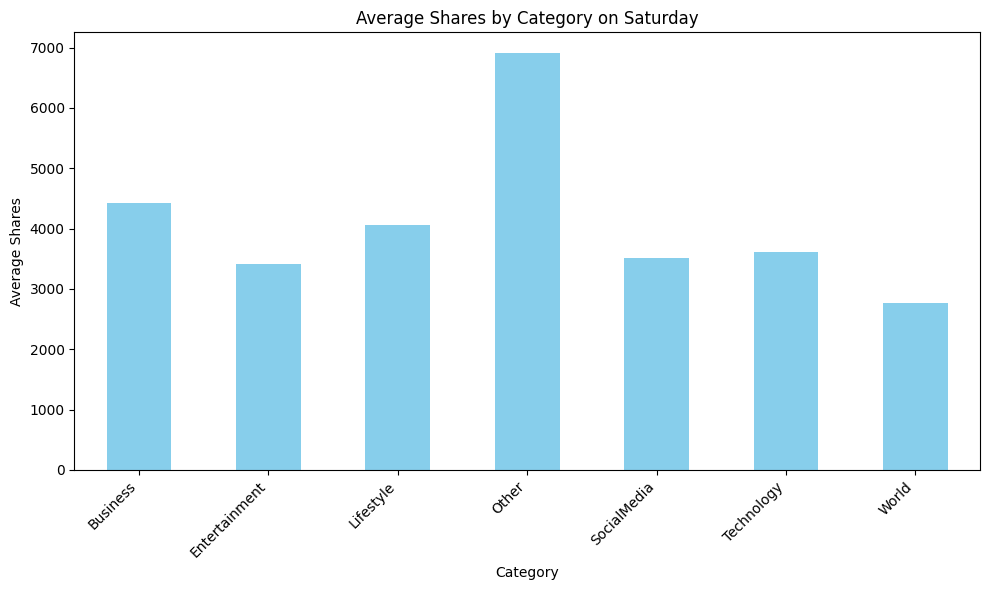

------------------------------------------------------------------------------------------------


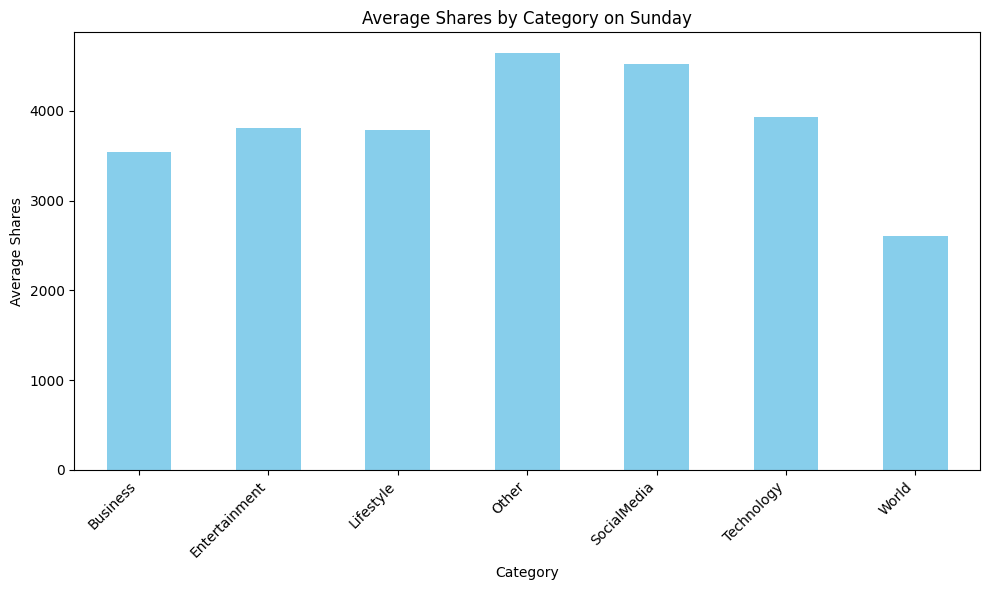

------------------------------------------------------------------------------------------------


In [35]:
import pandas as pd
from scipy.stats import f_oneway, ttest_ind

# Define function to perform pairwise t-tests with Bonferroni correction
def pairwise_t_tests_with_bonferroni(data, labels, alpha):
    corrected_alpha = alpha / (len(labels) * (len(labels) - 1) / 2)  # Corrected alpha level
    for i in range(len(labels)):
        for j in range(i+1, len(labels)):
            if len(data[labels[i]]) > 0 and len(data[labels[j]]) > 0:  # Check if data exists for both groups
                t_statistic, p_value = ttest_ind(data[labels[i]], data[labels[j]], equal_var=False)  # Perform t-test with unequal variances
                if p_value < corrected_alpha:
                    print(f"Significant difference between {labels[i]} and {labels[j]}: t={t_statistic: .4f}, p={p_value: .4f}")
                #else:
                    #print(f"No significant difference between {labels[i]} and {labels[j]}: t={t_statistic: .4f}, p={p_value: .4f}")


days = ['Saturday', 'Sunday']

for day in days:
    # Filter data for the specific day
    filtered_day_data = filtered_data[filtered_data['Day'] == day]

    # Group shares by category
    shares_by_category = filtered_day_data.groupby('Channel')['shares'].mean()

    # Plot bar plot
    plt.figure(figsize=(10, 6))
    shares_by_category.plot(kind='bar', color='skyblue')
    plt.title(f'Average Shares by Category on {day}')
    plt.xlabel('Category')
    plt.ylabel('Average Shares')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    print("------------------------------------------------------------------------------------------------")
